<h1><center>Machine Learning Applications</center></h1>
<h2><center>Week 2</center></h2>
<h2><center>Regression using Housing Data</center></h2>



In [38]:
# Imports
from google.colab import drive
from pathlib import Path
import tarfile
import urllib.request

import pandas as pd
import numpy as np

# Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression


In [2]:
# Plotting configs
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# Setting up the notebook.

# 1. Mounting the drive
drive.mount('/content/gdrive', force_remount=True)

# 2. Path on the drive to work in
week_number = 2
base_path = Path("/content/gdrive/MyDrive/mla/tech3300")
path = base_path.joinpath(f"week{week_number}")


Mounted at /content/gdrive


In [4]:
# Helper functions

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    save_path = path.joinpath(f"{fig_id}.{fig_extension}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(save_path, format=fig_extension, dpi=resolution)


# Preparing the data


In [5]:
# Load the data
def load_housing_data():
    tarball_path = path.joinpath("housing.tgz")
    if not tarball_path.is_file():
        path.mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=path)
    return pd.read_csv(path.joinpath("housing/housing.csv"))

df = load_housing_data()

In [6]:
df.keys()  # we only use data and target in this notebook

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Distribution of Data

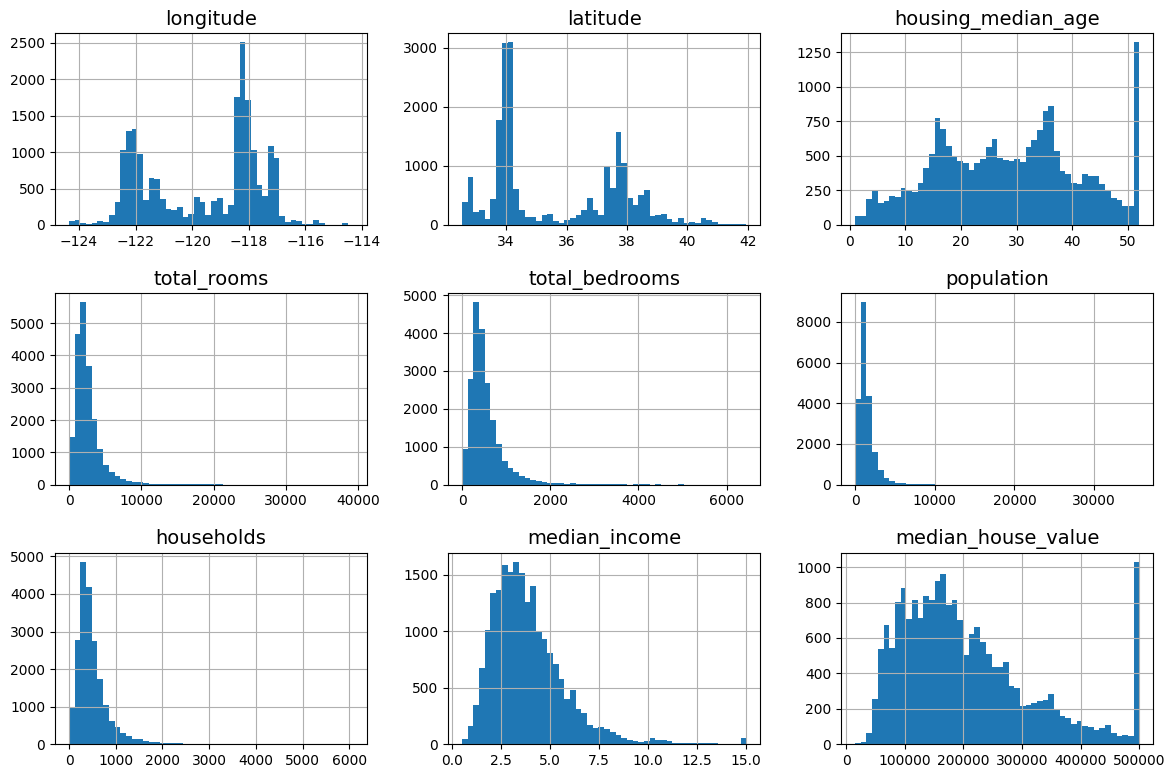

In [9]:
df.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

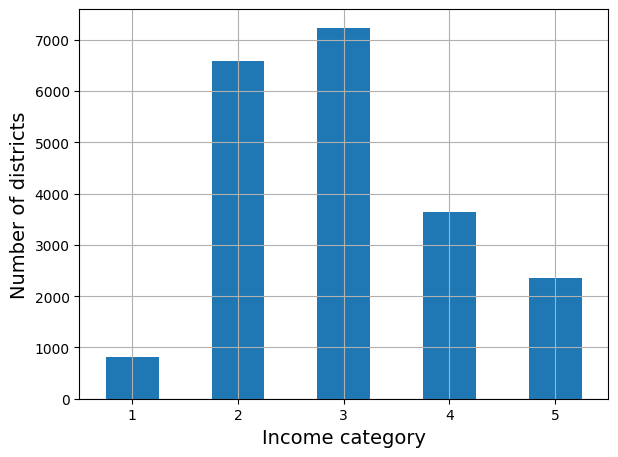

In [10]:
# Creating new feature

df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

## Visualizing Geographical Data

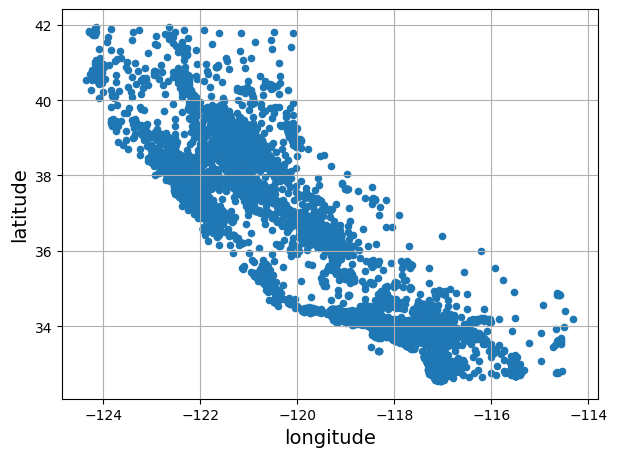

In [11]:
df.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")  # extra code
plt.show()

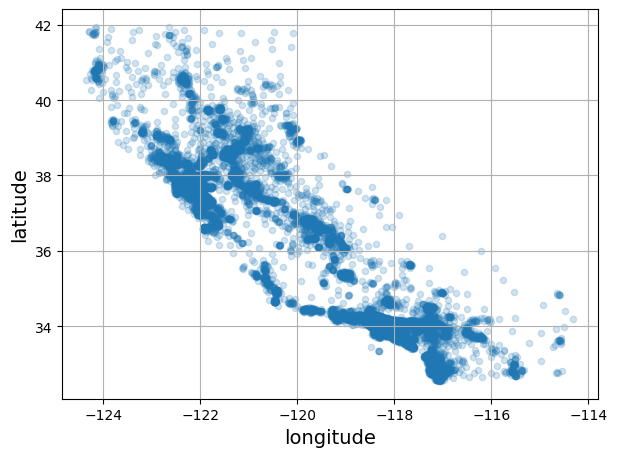

In [12]:
df.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")  # extra code
plt.show()

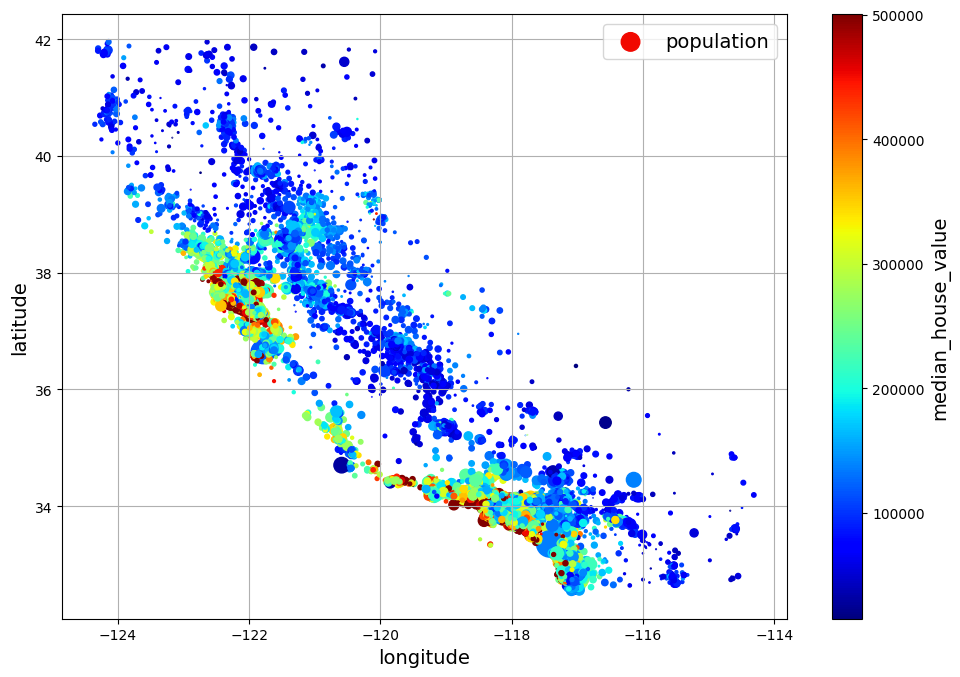

In [13]:
df.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=df["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

## Looking for correlations


In [14]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


<ipython-input-14-5db08072f607>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<font color='red'>Q. Which are top 5 correlated features?</font><br>

Ans. Think: Is negative value also considered as a correlation value.


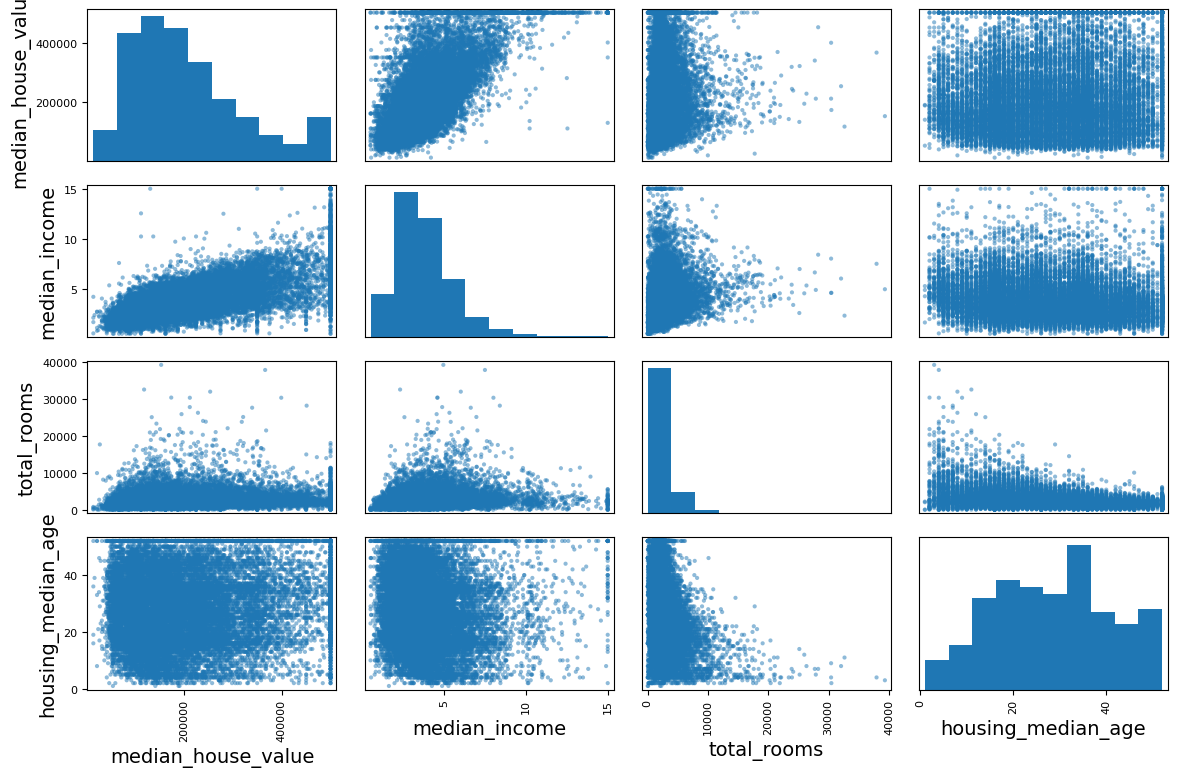

In [15]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
pd.plotting.scatter_matrix(df[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

## Data Cleaning

### Drop Null values

In [18]:
# Let's drop the null values
# P.S. There are many other strategies.
df.dropna(subset=["total_bedrooms"], inplace=True)

In [19]:
# Check if it worked.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  float64 
 3   total_rooms         20433 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20433 non-null  float64 
 6   households          20433 non-null  float64 
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  object  
 10  income_cat          20433 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.7+ MB


### Handling categorical features

In [20]:
# Check the feature values.
df_cat = df[["ocean_proximity"]]
df_cat.head(5)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


In [21]:
# Encode the categorical values as numerical values.
# P.S. There are
ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)

In [22]:
df_cat_encoded[:5]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [23]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [24]:
# Update the categorical values with the numerical values
df[["ocean_proximity"]] = df_cat_encoded

In [25]:
# It's good to keep on checking
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,3


### Feature Scaling

In [27]:
# Feature scaling
# P.S. There are many other strategies.

# Selecting the numerical features.
cols = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

# Scaling
std_scaler = StandardScaler()
df_num_std_scaled = std_scaler.fit_transform(df[cols])


In [28]:
# Update the feature values
df[cols] = df_num_std_scaled

# Checking
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,452600.0,3.0,5
1,-122.22,37.86,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,358500.0,3.0,5
2,-122.24,37.85,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,352100.0,3.0,5
3,-122.25,37.85,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,341300.0,3.0,4
4,-122.25,37.85,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,342200.0,3.0,3


## Train test split

In [31]:
## Create Test set - train/test split
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16346, 10), (4087, 10), (16346,), (4087,))

# Training and Evaluating a Linear Regression Model


For understanding the model [See documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [33]:
# Train the model
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train, y_train)

In [34]:
pred = lin_reg.predict(X_test)

In [36]:
# Compare predictions vs actuals
pred[:5]

array([ 70520.88582586, 169449.30042722, 273133.91186294, 197286.41081128,
       279202.66215493])

In [37]:
y_test[:5]

9710      85500.0
12949     92800.0
13081    340500.0
11228     71300.0
13018    211300.0
Name: median_house_value, dtype: float64

In [39]:
# Evaluating the loss - MSE
mean_squared_error(y_test, pred)

4951484039.907146

<font color='red'>Q. What does the above value means? Is the above value good?. If no, how to make it better?</font><br>

Ans. Loss value should be as less as possible. We can try to make it better by doing feature engineering (creating more meaningful columns), selecting different regression algorithms, i.e., decision tree, SVR, etc. For more [Linear models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

In [40]:
# Try new models here



THE END